# Task-3 Music Recommendation

# importing necessary libraries

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import gc
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier

In [5]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm

# Loading the datasets

In [6]:
from subprocess import check_output

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')
sample = pd.read_csv('sample_submission.csv')

# Exploring the datasets

In [7]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [8]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [9]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [10]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [11]:
sample.head()

,id,target
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
members.shape

(34403, 7)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [14]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [15]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


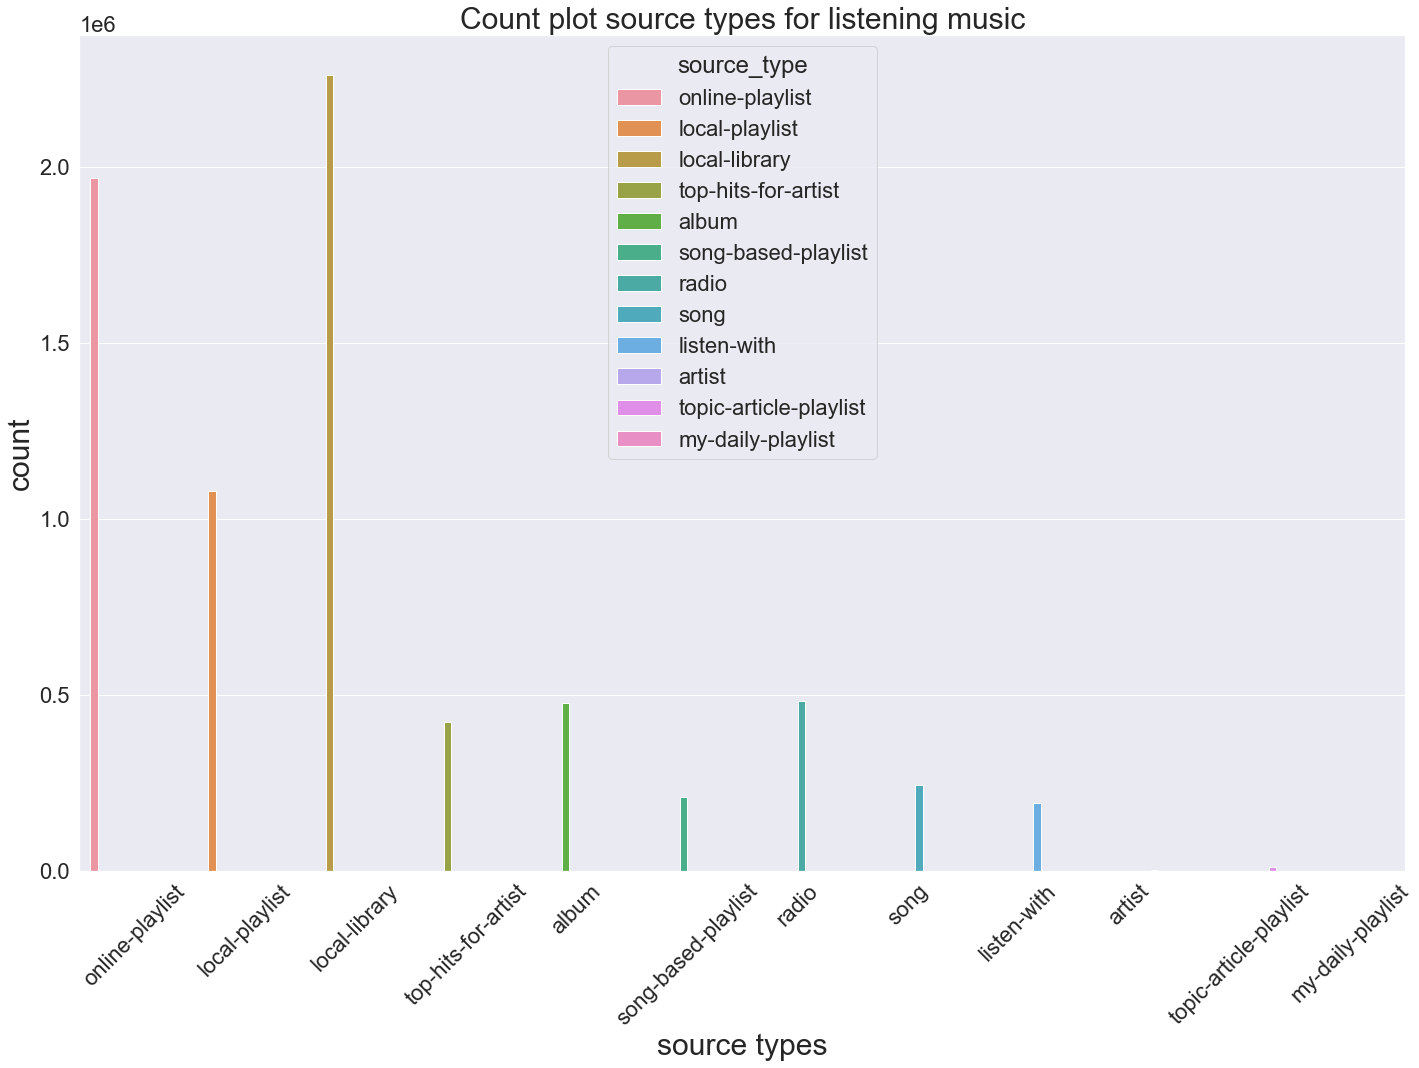

In [17]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type',hue='source_type',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

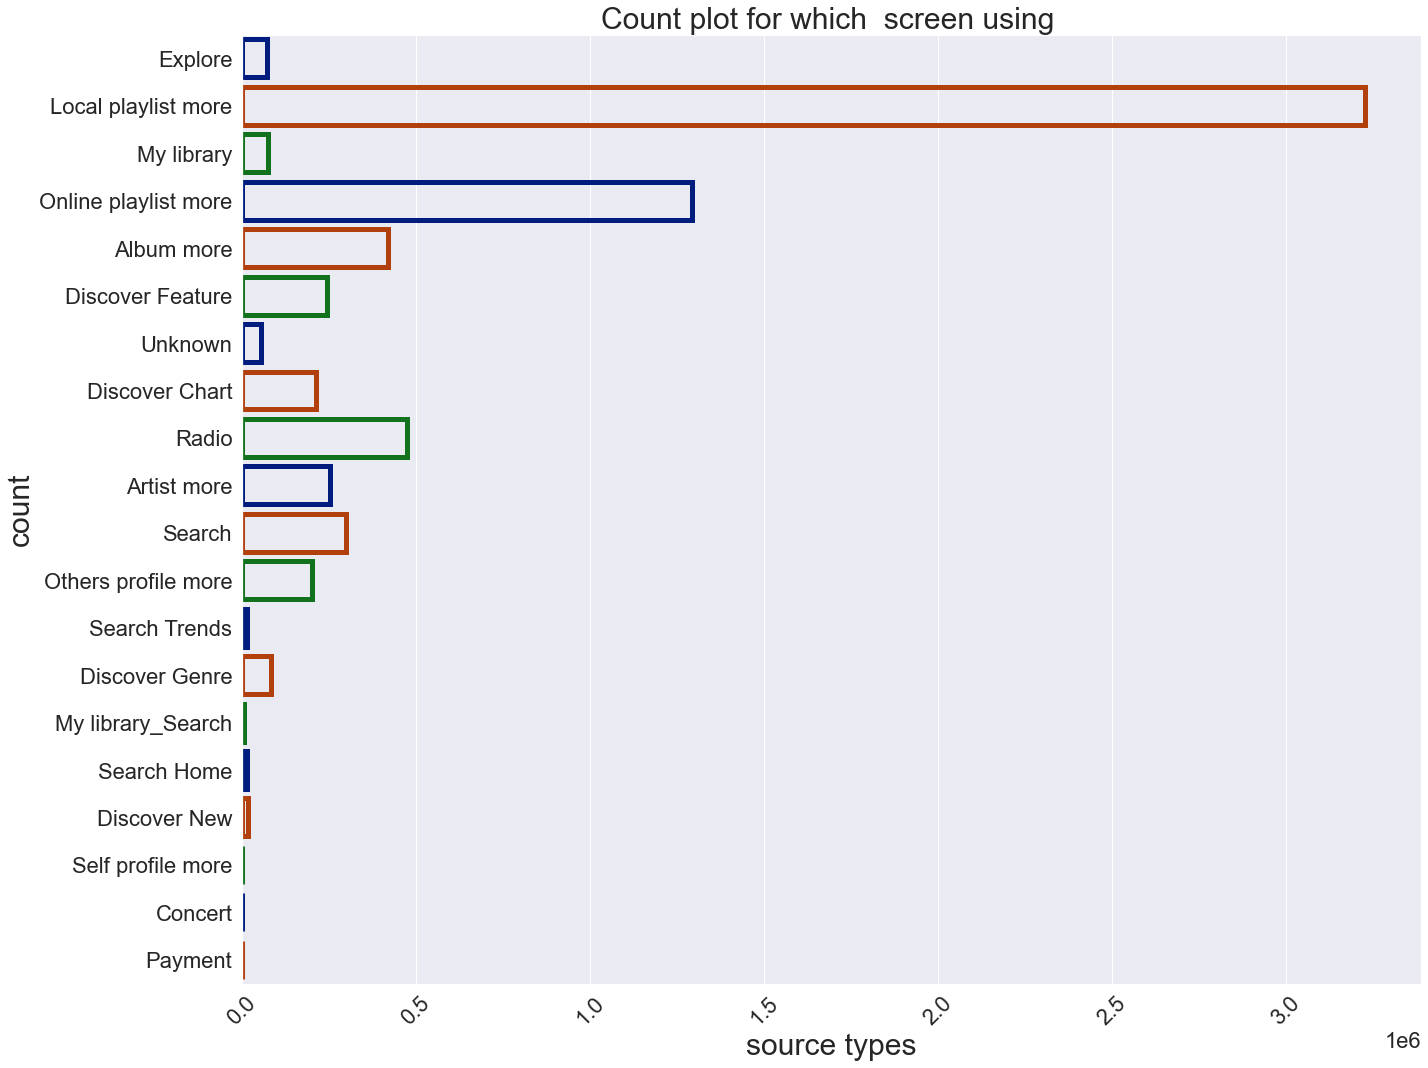

In [18]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train,facecolor=(0,0,0,0),linewidth=5,edgecolor=sns.color_palette('dark',3))
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which  screen using ',fontsize=30)
plt.tight_layout()

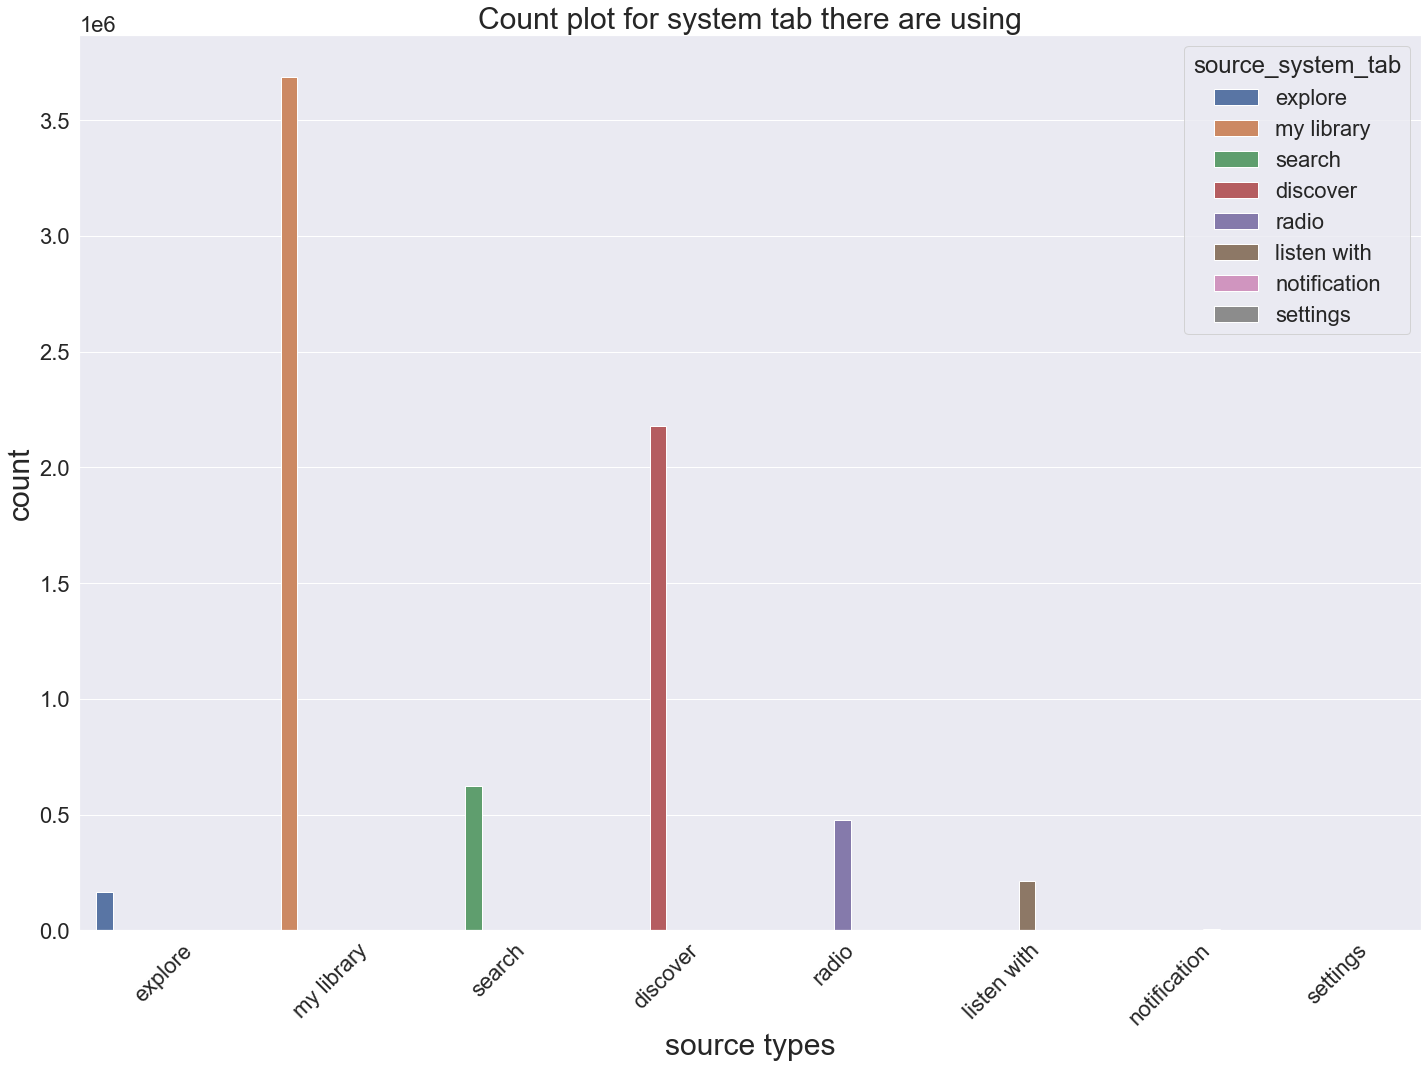

In [19]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()

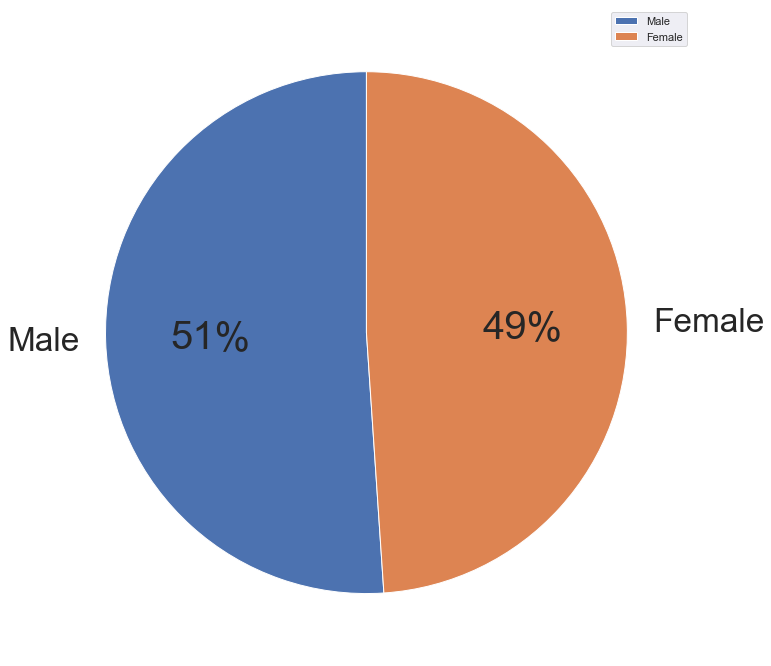

In [20]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (12, 12))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
for t in texts:
    t.set_size('smaller')
plt.legend()
plt.show()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64


<Figure size 1440x1440 with 0 Axes>

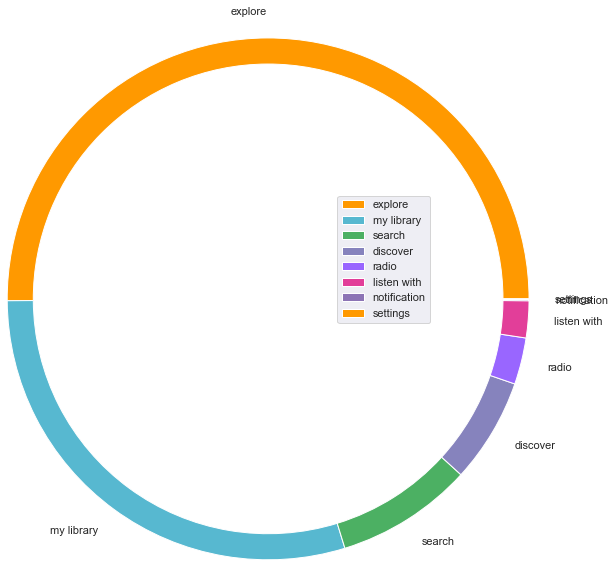

In [21]:
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
# Make data: I have 3 groups and 7 subgroups
group_names=['explore','my library','search','discover','radio','listen with','notification','settings']
group_size=pd.value_counts(train.source_system_tab)
print(group_size)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members.gender)
 
# Create colors
a, b, c,d,e,f,g,h=[plt.cm.autumn, plt.cm.GnBu, plt.cm.YlGn,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.0,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
  
plt.legend() 
# show it
plt.show()

In [22]:
print(members.describe())

               city            bd  registered_via  registration_init_time  \
count  34403.000000  34403.000000    34403.000000            3.440300e+04   
mean       5.371276     12.280935        5.953376            2.013994e+07   
std        6.243929     18.170251        2.287534            2.954015e+04   
min        1.000000    -43.000000        3.000000            2.004033e+07   
25%        1.000000      0.000000        4.000000            2.012103e+07   
50%        1.000000      0.000000        7.000000            2.015090e+07   
75%       10.000000     25.000000        9.000000            2.016110e+07   
max       22.000000   1051.000000       16.000000            2.017023e+07   

       expiration_date  
count     3.440300e+04  
mean      2.016901e+07  
std       7.320925e+03  
min       1.970010e+07  
25%       2.017020e+07  
50%       2.017091e+07  
75%       2.017093e+07  
max       2.020102e+07  


In [23]:
print(songs.describe())

        song_length      language
count  2.296320e+06  2.296319e+06
mean   2.469935e+05  3.237800e+01
std    1.609200e+05  2.433241e+01
min    1.850000e+02 -1.000000e+00
25%    1.836000e+05 -1.000000e+00
50%    2.266270e+05  5.200000e+01
75%    2.772690e+05  5.200000e+01
max    1.217385e+07  5.900000e+01


# statistics test on members data

C:\Users\killa\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'registration time ')

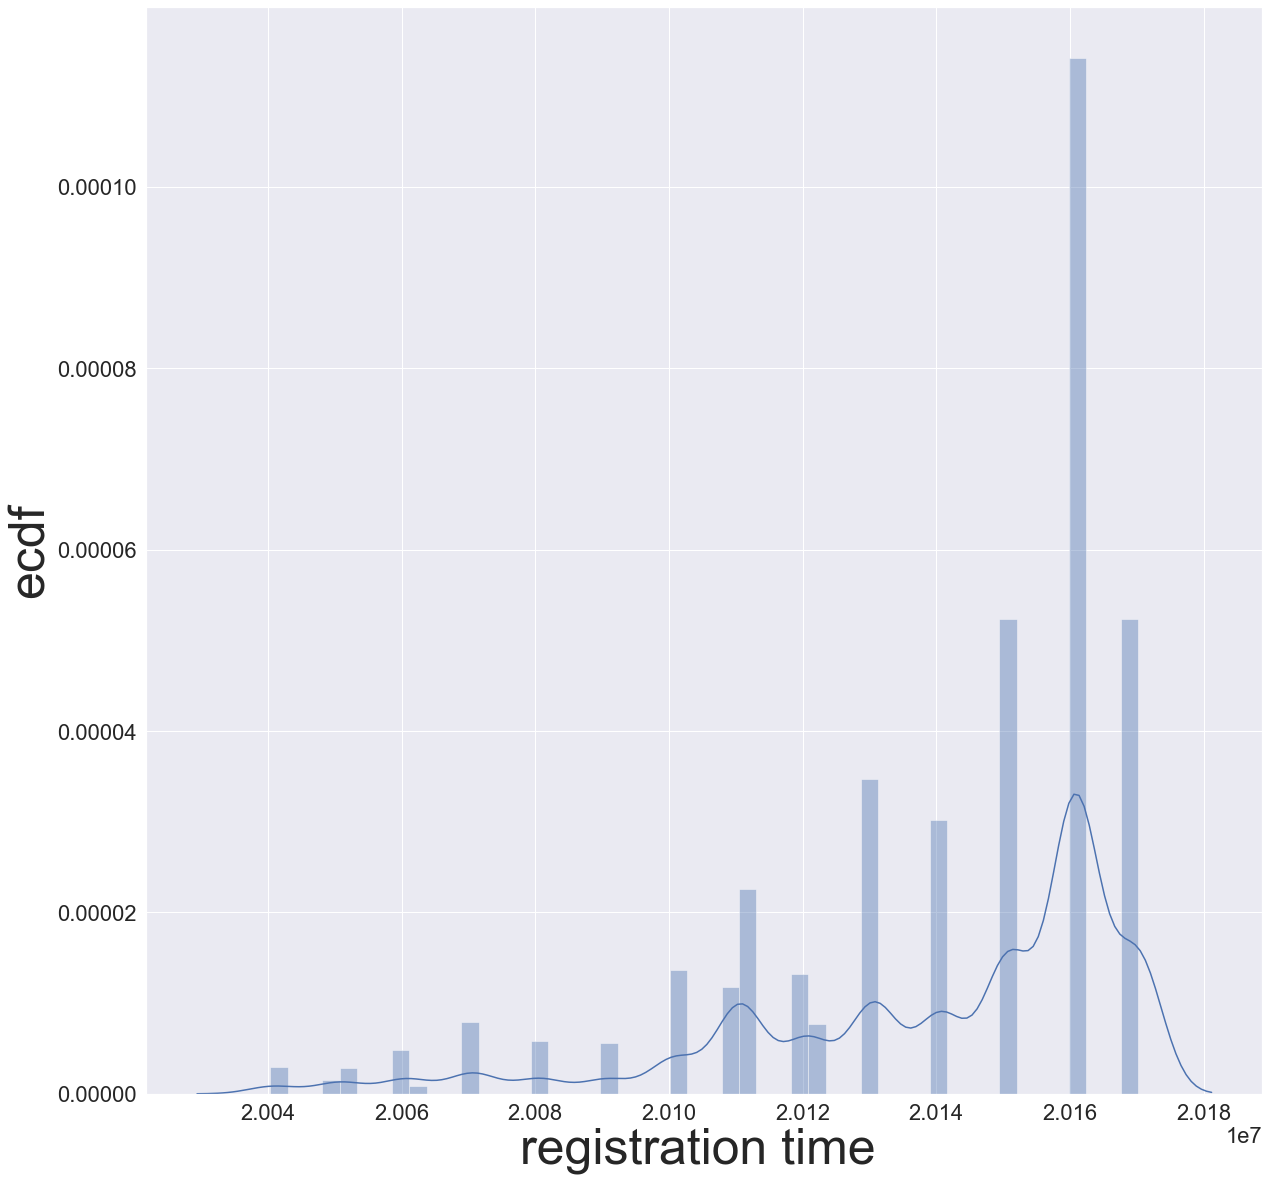

In [28]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
sns.distplot(members.registration_init_time)
sns.set(font_scale=2)
plt.ylabel('ecdf',fontsize=50)
plt.xlabel('registration time ' ,fontsize=50)

In [29]:
train_members = pd.merge(train, members, on='msno', how='inner')
train_merged = pd.merge(train_members, songs, on='song_id', how='outer')
print(train_merged.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=   
2  xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=   
3  s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=   
4  Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
2  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
3  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
4  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   

     source_screen_name      source_type  target  city    bd  gender  \
0               Explore  online-playlist     1.0   1.0   0.0     NaN   
1  Online playlist more  online-playlist     0.0  15.0  18.0    male   
2   Local playlist more    local-library     1.0   1.0   0.0  

In [30]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_merged = pd.merge(test_members, songs, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

          id                                          msno  \
0        0.0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
1  1035059.0  08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=   
2    89968.0  1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=   
3   972394.0  GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=   
4  2194574.0  HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=   

                                        song_id source_system_tab  \
0  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
1  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
2  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
3  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
4  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=          discover   

    source_screen_name          source_type  city    bd  gender  \
0  Local playlist more        local-library   1.0   0.0     NaN   
1  Local playlist more        local-library   5.0  29.0  female   
2  Local pl

In [32]:
del train_members
del test_members

In [34]:
print(train_merged.columns.to_series().groupby(train_merged.dtypes).groups)
print(test_merged.columns.to_series().groupby(test_merged.dtypes).groups)

{float64: ['target', 'city', 'bd', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'language'], object: ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'gender', 'genre_ids', 'artist_name', 'composer', 'lyricist']}
{float64: ['id', 'city', 'bd', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'language'], object: ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'gender', 'genre_ids', 'artist_name', 'composer', 'lyricist']}


# Analysis on missing values

<AxesSubplot:>

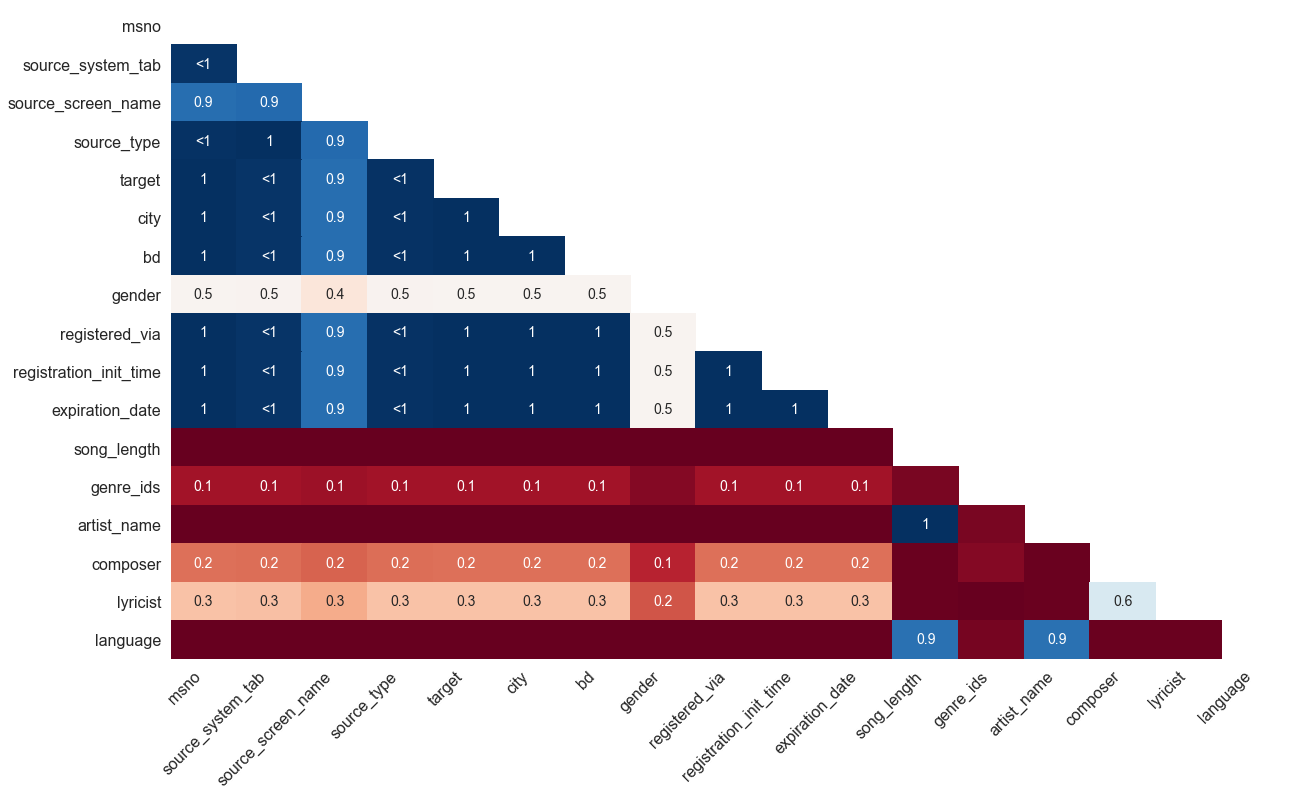

In [37]:
msno.heatmap(train_merged)

In [39]:
#--- Function to check if missing values are present and if so print the columns having them ---
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)
check_missing_values(test_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 1936406
source_system_tab : 1961255
source_screen_name : 2351210
source_type : 1957945
target : 1936406
city : 1936406
bd : 1936406
gender : 4897885
registered_via : 1936406
registration_init_time : 1936406
expiration_date : 1936406
song_length : 114
genre_ids : 205338
artist_name : 114
composer : 2591558
lyricist : 4855358
language : 150
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2071581
msno : 2071581
source_system_tab : 2080023
source_screen_name : 2234464
source_type : 2078878
city : 2071581
bd : 2071581
gender : 3123805
register

In [40]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))
       
replace_Nan_non_object(train_merged) 
replace_Nan_non_object(test_merged)  

In [41]:
#--- memory consumed by train dataframe ---
mem = train_merged.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
 
#--- memory consumed by test dataframe ---
mem = test_merged.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1350.117919921875 MB
Memory consumed by test set      :   670.9216995239258 MB


In [42]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

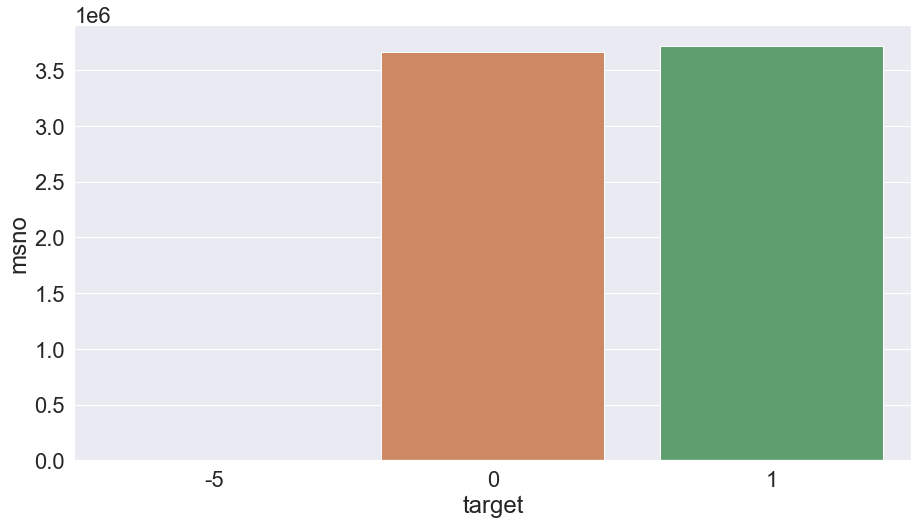

In [43]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

<AxesSubplot:xlabel='source_system_tab', ylabel='msno'>

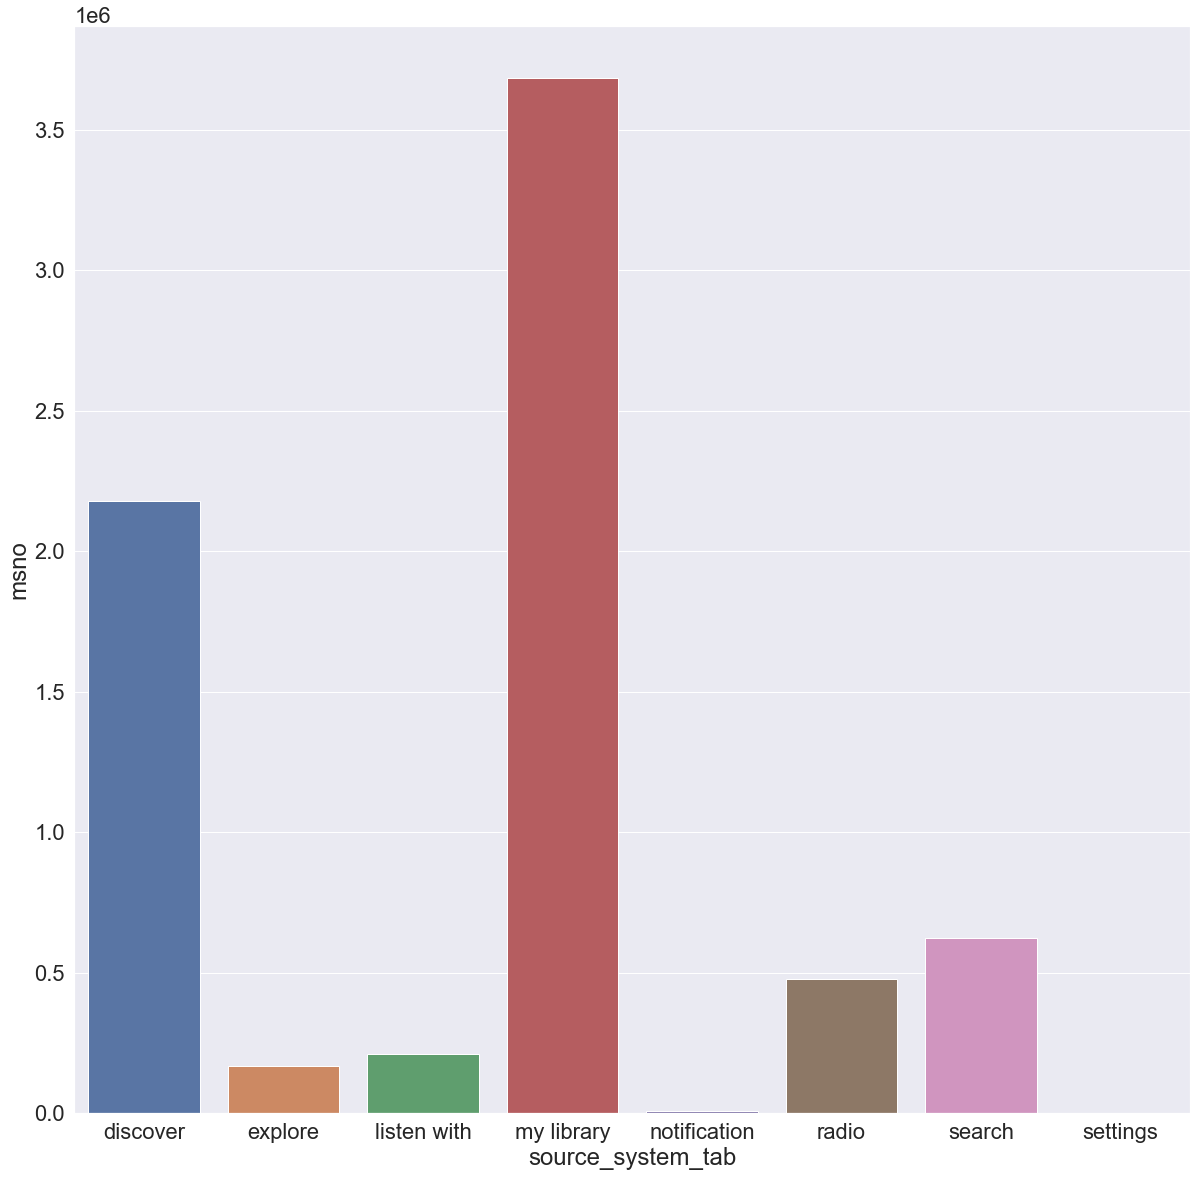

In [44]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
data=train_merged.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data)

[Text(0, 0, 'Album more'),
 Text(1, 0, 'Artist more'),
 Text(2, 0, 'Concert'),
 Text(3, 0, 'Discover Chart'),
 Text(4, 0, 'Discover Feature'),
 Text(5, 0, 'Discover Genre'),
 Text(6, 0, 'Discover New'),
 Text(7, 0, 'Explore'),
 Text(8, 0, 'Local playlist more'),
 Text(9, 0, 'My library'),
 Text(10, 0, 'My library_Search'),
 Text(11, 0, 'Online playlist more'),
 Text(12, 0, 'Others profile more'),
 Text(13, 0, 'Payment'),
 Text(14, 0, 'Radio'),
 Text(15, 0, 'Search'),
 Text(16, 0, 'Search Home'),
 Text(17, 0, 'Search Trends'),
 Text(18, 0, 'Self profile more'),
 Text(19, 0, 'Unknown')]

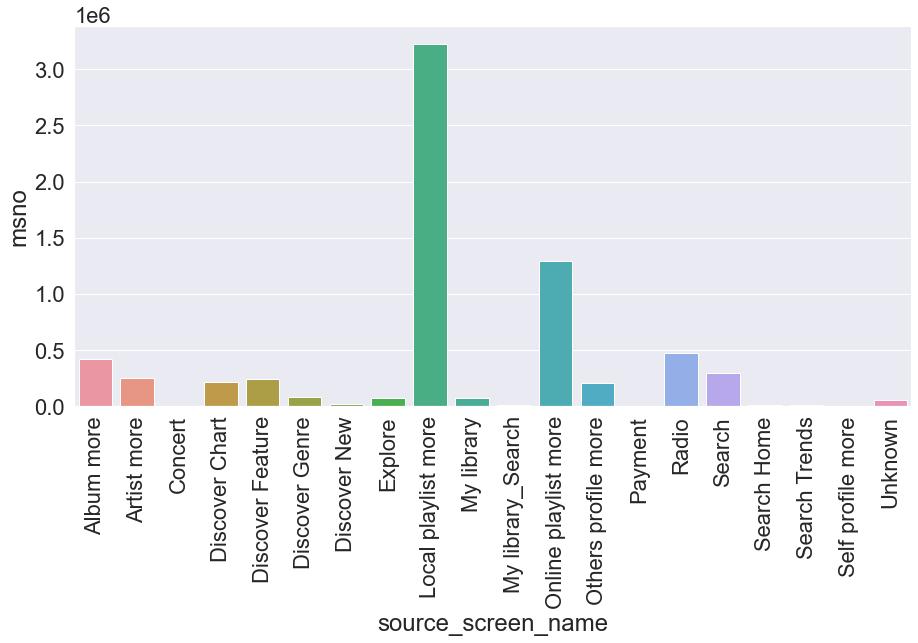

In [45]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'album'),
 Text(1, 0, 'artist'),
 Text(2, 0, 'listen-with'),
 Text(3, 0, 'local-library'),
 Text(4, 0, 'local-playlist'),
 Text(5, 0, 'my-daily-playlist'),
 Text(6, 0, 'online-playlist'),
 Text(7, 0, 'radio'),
 Text(8, 0, 'song'),
 Text(9, 0, 'song-based-playlist'),
 Text(10, 0, 'top-hits-for-artist'),
 Text(11, 0, 'topic-article-playlist')]

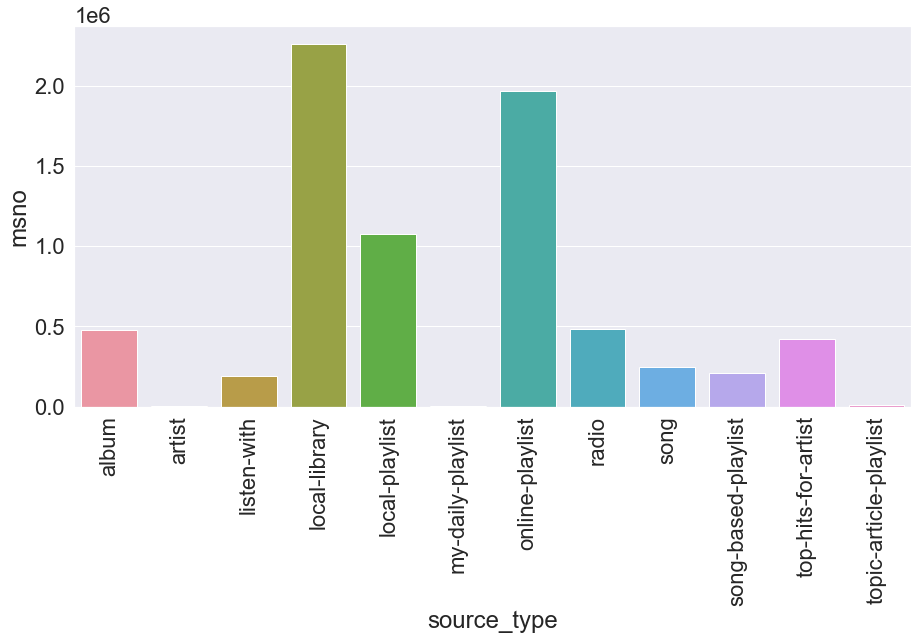

In [46]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '-1'),
 Text(2, 0, '3'),
 Text(3, 0, '10'),
 Text(4, 0, '17'),
 Text(5, 0, '24'),
 Text(6, 0, '31'),
 Text(7, 0, '38'),
 Text(8, 0, '45'),
 Text(9, 0, '52'),
 Text(10, 0, '59')]

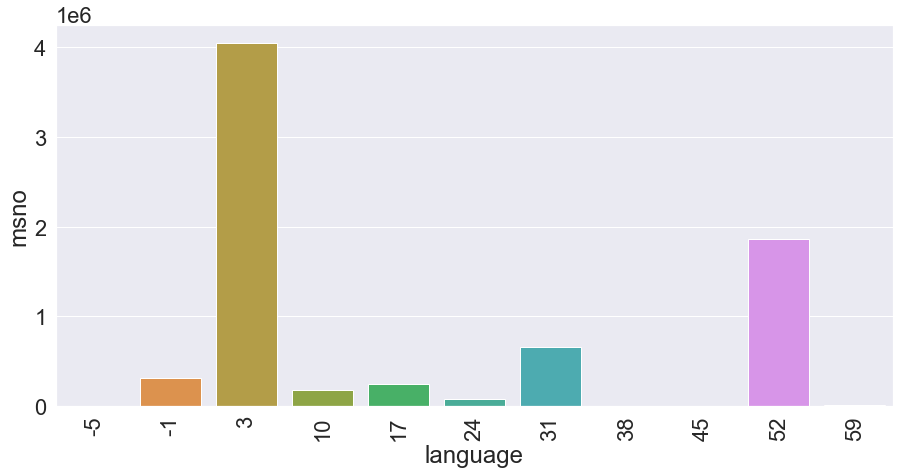

In [47]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='language', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '7'),
 Text(4, 0, '9'),
 Text(5, 0, '13')]

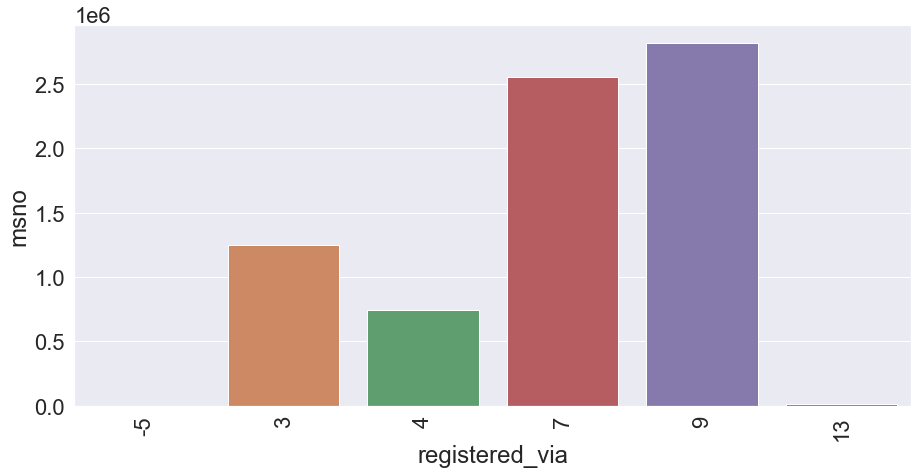

In [50]:
data = train_merged.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='registered_via', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')


[Text(0, 0, '-5'),
 Text(1, 0, '1'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22')]

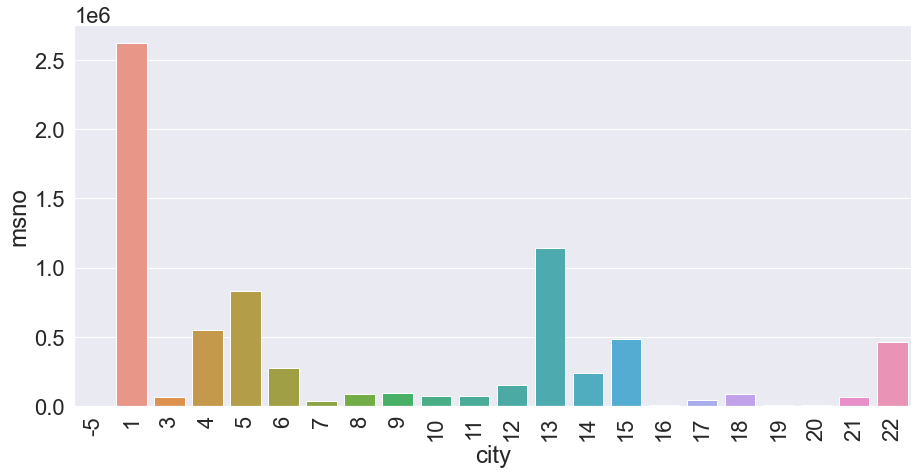

In [51]:
print(train_merged.columns)
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='city', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

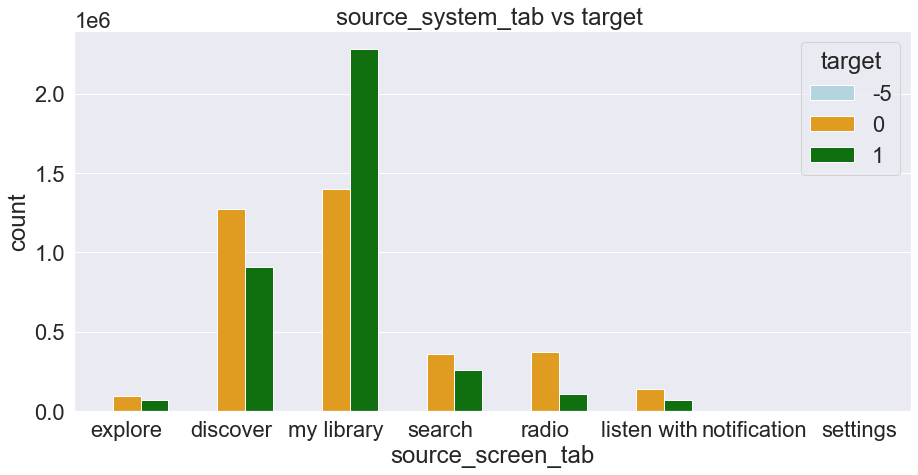

In [52]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_merged,palette=['lightblue','orange','green'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

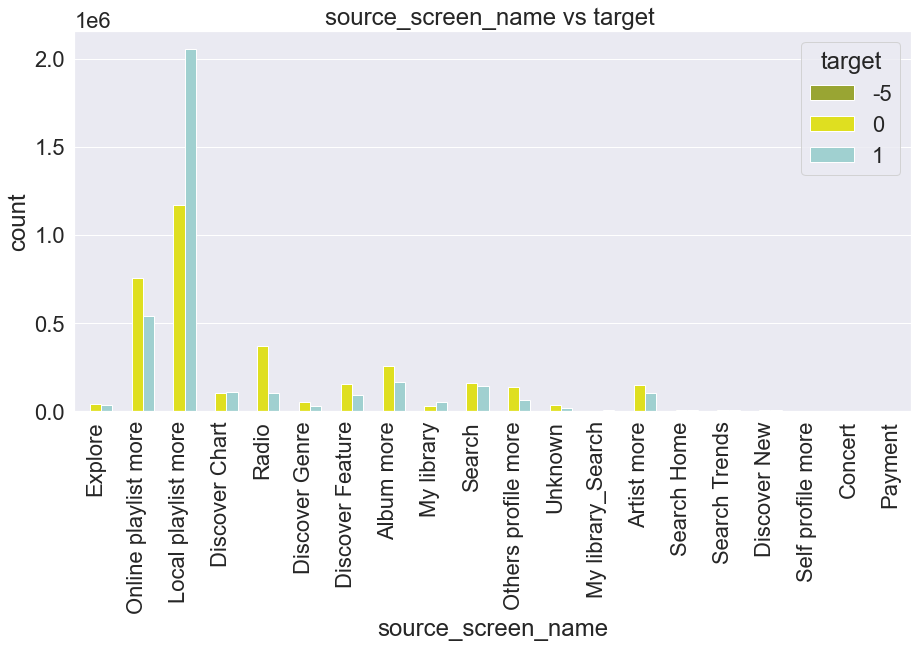

In [53]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_screen_name",data=train_merged,palette=['#A8B820','yellow','#98D8D8'],hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.xticks(rotation='90')
plt.show()

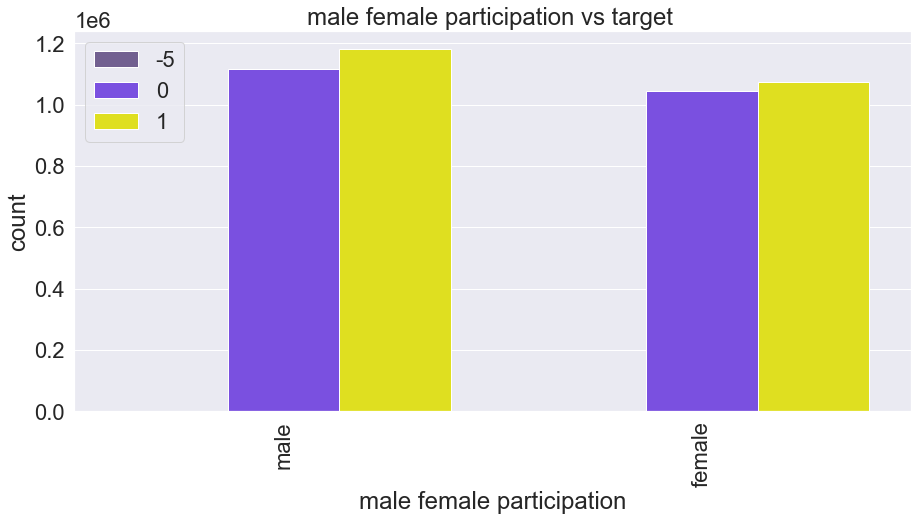

In [54]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_merged,palette=['#705898','#7038F8','yellow'],hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.legend(loc='upper left')
plt.show()

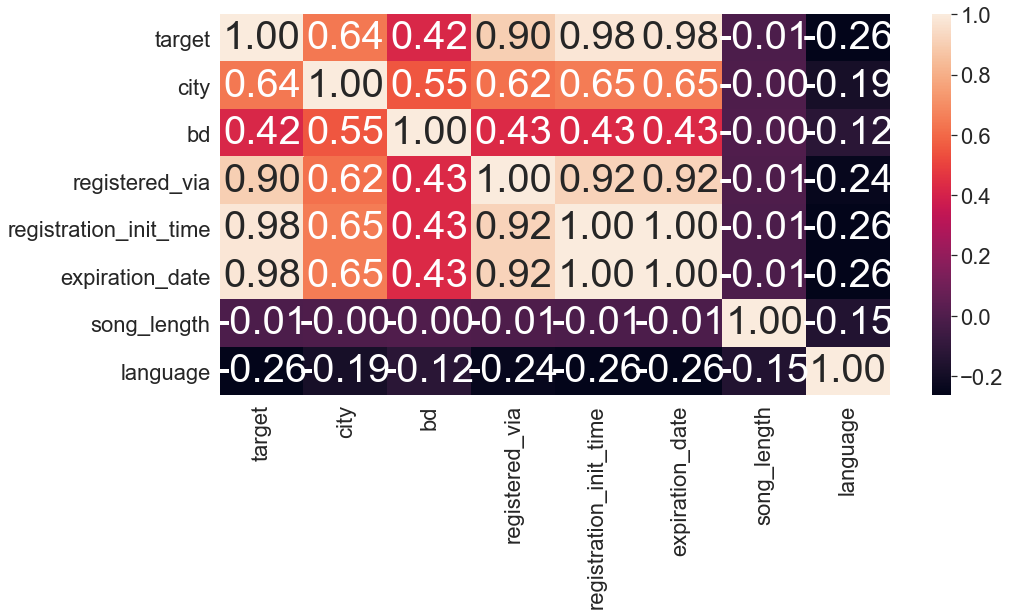

In [55]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.heatmap(data=train_merged.corr(),annot=True,fmt=".2f")

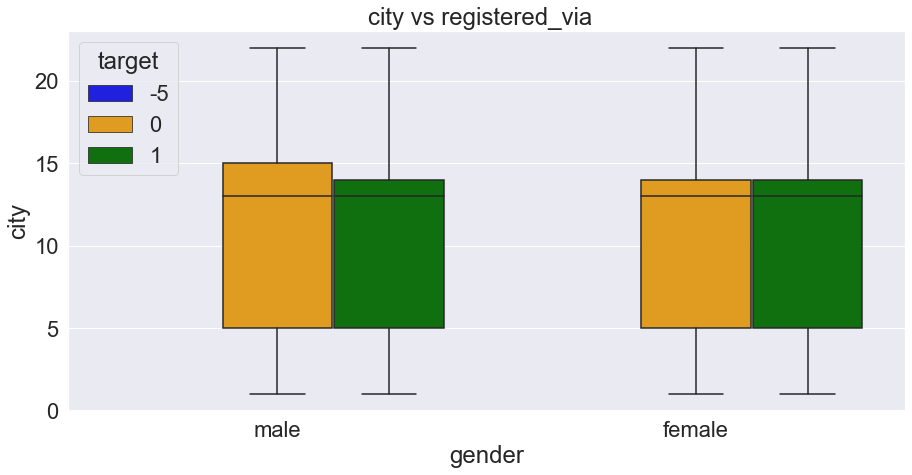

In [56]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="gender",y="city",data=train_merged,palette=['blue','orange','green'],hue="target")
plt.xlabel("gender")
plt.ylabel("city")
plt.title("city vs registered_via  ")
plt.show()

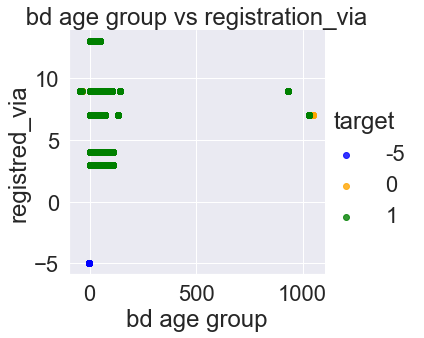

In [57]:
ax=sns.lmplot(x="bd",y="registered_via",data=train_merged,palette=['blue','orange','green'],hue="target",fit_reg=False)
plt.xlabel("bd age group")
plt.ylabel("registred_via")
plt.title(" bd age group vs registration_via ")
plt.show()

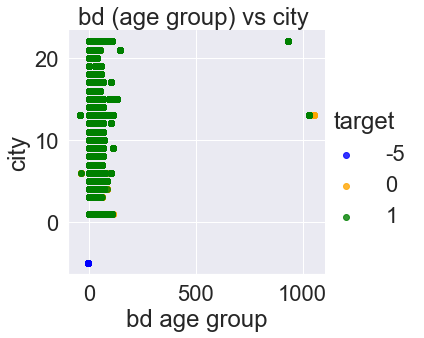

In [58]:
ax=sns.lmplot(x="bd",y="city",data=train_merged,palette=['blue','orange','green'],hue="target",fit_reg=False)
plt.xlabel("bd age group")
plt.ylabel("city")
plt.title("bd (age group) vs city ")
plt.show()

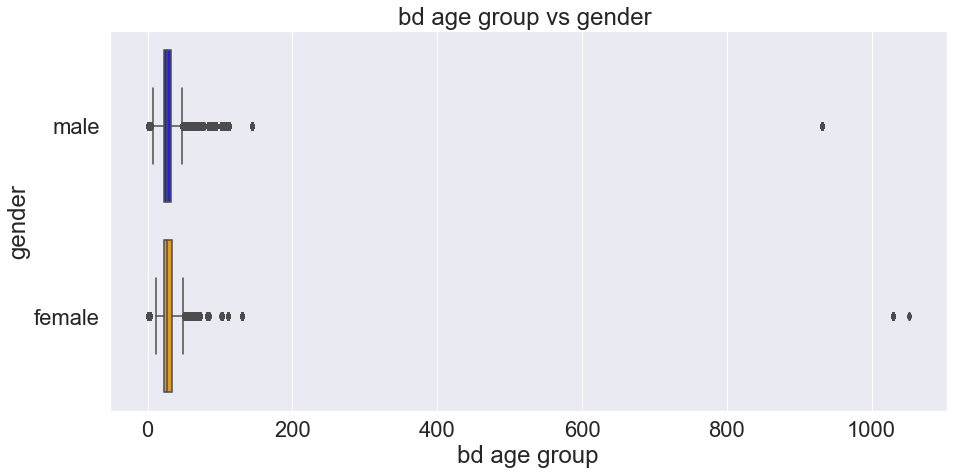

In [59]:
#remomving outlier from bd age group column
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="bd",y="gender",data=train_merged,palette=['blue','orange','green'])
plt.xlabel("bd age group")
plt.ylabel("gender")
plt.title("bd age group vs gender ")
plt.show()